# Academic test

In [91]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

### Parameters to be used 

In [92]:
T = 1
gamma = 1
alpha_g = 2
beta_g = 1.27 * 10**(-3)
sigma_g = 0.1863
r = 0.02

In [93]:
g_bar = 0.5
g_hat = 2*g_bar
b_hat = 1

## First Numerical Method 

### Parameters to be used 

In [94]:
omega = 2
eps = 10**(-5)

In [95]:
space_steps = 32
time_steps = 40

In [96]:
delta_tau = gamma/time_steps
time_mesh = [n*delta_tau for n in range(time_steps+1)]

Remember: $\hat{B} \in [0,1]$ and $\hat{G} \in [0,1]$.

In [97]:
delta_B = 1/space_steps
B_mesh = [i*delta_B for i in range(space_steps+1)]

delta_G = 1/space_steps
G_mesh = [j*delta_G for j in range(space_steps+1)]

We must solve the linear system: $C(\hat{G})P_i^{n+1} = b_i^n$ at each time step and for each value of $i=1,2,\dots,N_{\hat{B}}-1$.

## Analytical Solution

In [98]:
def analytical_solution(B, G_tilde, T = 1, t = 0):
    return np.exp((T-t)*B*G_tilde)

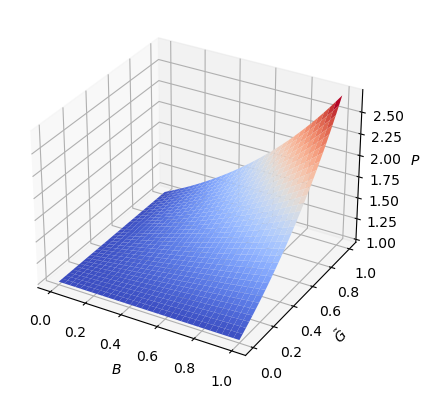

In [99]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the mesh in polar coordinates and compute corresponding Z.
B, G_tilde = np.meshgrid(B_mesh, G_mesh)

Z = analytical_solution(B, G_tilde)

# Plot the surface.
ax.plot_surface(B, G_tilde, Z, cmap=cm.coolwarm)

# Tweak the limits and add latex math labels.
ax.set_xlabel(r'$B$')
ax.set_ylabel(r'$\tilde{G}$')
ax.set_zlabel(r'$P$')

plt.show()

### $C(\hat{G}) $ matrix 

In this academic test there is no seasonality, that is, $f=0$.

In [100]:
def f():
    return 0

In [101]:
def c1():
    c1_value = 1 + 0.5*r*delta_tau + 0.5* (g_hat**2 * sigma_g**2 * delta_tau)/(delta_G**2)
    return c1_value

def c2(j):
    c2_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) - 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c2_value

def c3(j):
    c3_value = -0.5*(g_hat**2 * sigma_g**2 * delta_tau)/(2 * delta_G**2) + 0.5 * g_hat * alpha_g *\
    delta_tau * (f() - G_mesh[j]*g_hat-g_bar + beta_g*omega/(2*alpha_g))/(2*delta_G)
    return c3_value

In [102]:
C_matrix = [[0 for i in range(space_steps-1)] for j in range(space_steps-1)]

In [103]:
#main diagonal
for i in range(space_steps-1):
    C_matrix[i][i] = c1()
    
#top diagonal
for i in range(space_steps-2):
    C_matrix[i][i+1] = c2(i)
    
#bottom diagonal
for i in range(space_steps-2):
    C_matrix[i+1][i] = c3(i)

### $\left( b_i^n \right)_j$ vector 

This is a vector to be updated in each time step. First you solve the linear system and get to a array $P$ and then subtitute it on the right-hand side of the equation to get the $b$ vector.

In [104]:
def mult_factor1():
    m1_value = (1 - r*delta_tau*0.5) - (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(delta_G**2)
    return m1_value

def mult_factor3():
    m3_value = (sigma_g**2 * g_hat**2 * delta_tau * 0.5)/(2 * delta_G**2)
    return m3_value

def mult_factor5():
    m5_value = 0.5 * g_hat * delta_tau * beta_g / (4*delta_G)
    return m5_value


In [105]:
def m(theta, P, omega=2):
    if P + theta/(2*omega) <=0:
        a = -theta - 2*omega*P
        return a
    else:
        b = theta + 2*omega*P + omega**2 - omega * np.sqrt(4*theta + 8*omega*P + omega**2)
        return b

## Solving the linear system and updating values 

In [115]:
#Initializing the variables
P = [[1 for i in range(space_steps-1)] for j in range(time_steps)]
theta = [[1 for i in range(space_steps-1)] for j in range(time_steps)]

In [116]:
def h(n,i,j):
    t = [T-time_mesh[n] for n in range(len(time_mesh))]
    G_tilde = [G_mesh[i] * g_hat - g_bar for i in range(len(G_mesh))]
    B = [B_mesh[i] * b_hat for i in range(len(G_mesh))]
    
    h_value = np.exp( (T-t[n]) * B[i] * G_tilde[j] ) * \
    (-B[i]*G_tilde[j] + 1/2 * sigma_g**2 * t[n]**2 * B[i]**2 - \
    t[n]*B[i]*alpha_g* (f() + (beta_g/alpha_g) * np.exp( (T-t[n])*B[i]*\
    G_tilde[j])-G_tilde[j] ) - np.exp(G_tilde[j]) * time_mesh[n] * G_tilde[j] -r)
    return h_value

In [120]:
#remember to update boundary conditions
for n in range(time_steps):
    theta_n1 = theta.copy()
    P_n = P.copy()
    b = [0 for j in range(space_steps-1)]

    #parameters to start the cycle
    criterion = 1
    k=0
    
    while criterion > eps:
        
        #constructing the b vector
        for j in range(1,space_steps-2):
            b[j] = mult_factor1()*P_n[k][j] +\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j+1] +\
            mult_factor3()*(P_n[k][j+1] + P_n[k][j-1])-\
            ((alpha_g*g_hat*delta_tau*0.5 * (f()-G_mesh[j]*g_hat-g_bar + beta_g/alpha_g*P_n[k][j]))/(2*delta_G))*P_n[k][j-1] +\
            mult_factor5()*(theta_n1[k][j+1]-theta_n1[k][j-1]) + \
            mult_factor5()*(theta_n1[0][j+1]-theta_n1[0][j-1]) +\
            h(n,10,j)
        #########
        
        #solving the linear system
        newP = np.linalg.solve(C_matrix, b)
        P_n[k] = newP
        ######
        
        #update theta
        theta_updated = [m(theta_n1[k][j], newP[j]) for j in range(space_steps-1)] #check this
        theta_n1[k+1] = theta_updated
        ######
        
        #stopping test
        theta_updated_array = np.array(theta_updated)
        theta_k_array = np.array(theta_n1[k])
        numerator = np.max(theta_updated_array - theta_k_array)
        denominator = np.max(theta_updated_array)
        criterion = numerator/denominator
        #####
        k+=1
    print(k)
        
    theta[n] = theta_updated
    P[n] = newP


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
4
4
2
2
2
2
2
2
2
2
2


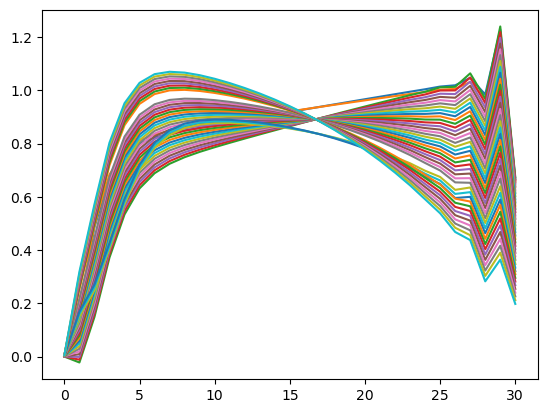

In [121]:
for i in range(len(P)):
    plt.plot(P[i])

comparing the solution with n=10, i=1

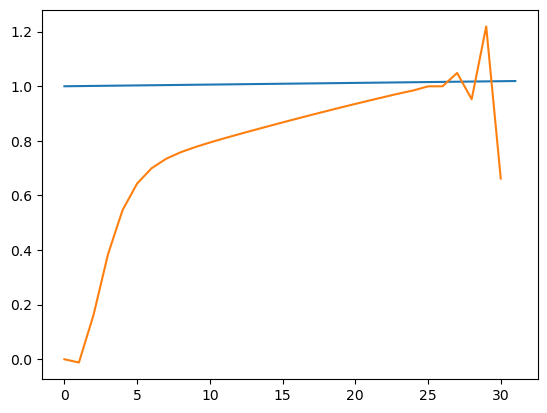

In [128]:
sol = []
for i in range(space_steps):
    sol.append(np.exp((T-time_mesh[15])*B_mesh[1]*G_mesh[i]))
plt.plot(sol)
plt.plot(P[3])

In [74]:
b

[0,
 2.370633080101483,
 4.776719320592069,
 5.461669991847283,
 5.641692925255762,
 5.668697988292892,
 5.646949520811223,
 5.608056310484532,
 5.5617755769294295,
 5.511130161177062,
 5.457016069162496,
 5.399639769559837,
 5.338976658353362,
 5.274920414579692,
 5.20733258755492,
 5.136059292492806,
 5.06093683467105,
 4.981793529034377,
 4.89845017706174,
 4.81072010346942,
 4.71840868866635,
 4.621315119821141,
 4.519218600482606,
 4.411964529773908,
 4.298934337519201,
 4.182155378749792,
 4.048767123876598,
 3.9661315110158313,
 3.584495691681038,
 4.648174183239212,
 0]